<a href="https://colab.research.google.com/github/zambbo/CNN-DialectDetector/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import re
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import pickle
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler

In [29]:
index2region={0:'gangwon', 1:'gyeongsang', 2:'jeonla', 3:'chungcheong', 4:'jeju'}
region2index = {v:k for k,v in index2region.items()}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
# 데이터 셋 구성 (small dataset)
dataset_dir = '/content/drive/MyDrive/DialectDataset/small_dataset/'

In [31]:
region_dir = glob(dataset_dir)
region_dir

['/content/drive/MyDrive/DialectDataset/small_dataset/']

In [32]:
for k, v in index2region.items():
    exec(f"{v}_dirs = glob(dataset_dir+'*_{v}/*')")
jeonla_dirs

['/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000014',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000012',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000019',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000006',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000015',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000032',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000027',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000018',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000005',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000024']

In [33]:
def make_tuple_data(dirs, max_num):
    for i, region_dir in enumerate(dirs):
        if i>=max_num:break
        spectro_path = glob(region_dir+'/*_spectro.pickle')[0]
        mfcc_path = glob(region_dir+'/*_mfcc.pickle')[0]
        chroma_path = glob(region_dir+'/*_chroma.pickle')[0]
        
        with open(spectro_path, "rb") as f:
            spectro = pickle.load(f)
        with open(mfcc_path, "rb") as f:
            mfcc = pickle.load(f)
        with open(chroma_path, "rb") as f:
            chroma = pickle.load(f)

        if i == 0:
            spectro_data = spectro
            mfcc_data = mfcc
            chroma_data = chroma
        else:
            spectro_data = np.concatenate([spectro_data,spectro], axis=0)
            mfcc_data = np.concatenate([mfcc_data,mfcc], axis=0)
            chroma_data = np.concatenate([chroma_data,chroma], axis=0)
    if max_num ==0:return []
        
    r_data = [(s,m,c) for s,m,c in zip(spectro_data,mfcc_data,chroma_data)]
        
    return r_data
jeonla_data = make_tuple_data(jeonla_dirs, 5)
chungcheong_data = make_tuple_data(chungcheong_dirs, 5)
gyeongsang_data = make_tuple_data(gyeongsang_dirs, 5)
jeju_data = make_tuple_data(jeju_dirs, 5)
gangwon_data = make_tuple_data(gangwon_dirs, 5)

def print_data(r_data, region):
    if len(r_data)==0: return
    print(f"{region} data num: ", len(r_data))
    print(f"{region} tuple size", len(r_data[0]))
    print(f"{region} spec shape", r_data[0][0].shape)

print_data(jeonla_data, 'jeonla')
print_data(chungcheong_data, 'chungcheong')
print_data(gyeongsang_data, 'gyeongsang')
print_data(jeju_data, 'jeju')
print_data(gangwon_data, 'gangwon')

jeonla data num:  454
jeonla tuple size 3
jeonla spec shape (201, 501)
chungcheong data num:  530
chungcheong tuple size 3
chungcheong spec shape (201, 501)
gyeongsang data num:  402
gyeongsang tuple size 3
gyeongsang spec shape (201, 501)
jeju data num:  452
jeju tuple size 3
jeju spec shape (201, 501)
gangwon data num:  468
gangwon tuple size 3
gangwon spec shape (201, 501)


In [34]:
jeonla_data_l = []
for data in jeonla_data:
    y = [0,0,0,0,0]
    y[region2index['jeonla']] = 1
    jeonla_data_l.append((data,y))

chungcheong_data_l = []
for data in chungcheong_data:
    y = [0,0,0,0,0]
    y[region2index['chungcheong']] = 1
    chungcheong_data_l.append((data,y))

gyeongsang_data_l = []
for data in gyeongsang_data:
    y = [0,0,0,0,0]
    y[region2index['gyeongsang']] = 1
    gyeongsang_data_l.append((data,y))

jeju_data_l = []
for data in jeju_data:
    y = [0,0,0,0,0]
    y[region2index['jeju']] = 1
    jeju_data_l.append((data,y))

gangwon_data_l = []
for data in gangwon_data:
    y = [0,0,0,0,0]
    y[region2index['gangwon']] = 1
    gangwon_data_l.append((data,y))

In [35]:
datasumup = np.concatenate([jeonla_data_l, chungcheong_data_l, gangwon_data_l, jeju_data_l, gyeongsang_data_l], axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [36]:
print(len(jeonla_data))
print(len(jeonla_data[0]))
print(len(jeonla_data[0][0]))
print(jeonla_data[0][0][0].shape)
print(jeonla_data[0][1])

454
3
201
(501,)
[[-803.2581 -803.2581 -803.2581 ... -803.2581 -803.2581 -803.2581]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 ...
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]]


In [37]:
from sklearn.preprocessing import normalize
jd = normalize(jeonla_data[0][0])
jd

array([[-0.06697986, -0.06697986, -0.06697986, ..., -0.06697986,
        -0.06697986, -0.06697986],
       [-0.0872501 , -0.0872501 , -0.0872501 , ..., -0.0872501 ,
        -0.0872501 , -0.0872501 ],
       [-0.08802105, -0.08802105, -0.08802105, ..., -0.08802105,
        -0.08802105, -0.08802105],
       ...,
       [-0.04480063, -0.04480063, -0.04480063, ..., -0.04480063,
        -0.04480063, -0.04480063],
       [-0.04471976, -0.04471976, -0.04471976, ..., -0.04471976,
        -0.04471976, -0.04471976],
       [-0.04468486, -0.04468486, -0.04468486, ..., -0.04468486,
        -0.04468486, -0.04468486]], dtype=float32)

In [38]:
from sklearn.preprocessing import normalize
class MultiModalDataset(Dataset):

    def __init__(self, data):

        self.data = data

    def __getitem__(self, idx):
        datas, label = self.data[idx]
        spec, mfcc, chroma = datas
        spec, mfcc, chroma = normalize(spec), normalize(mfcc), normalize(chroma)
        spec, mfcc, chroma = torch.tensor(spec, dtype=torch.float32), torch.tensor(mfcc, dtype=torch.float32), torch.tensor(chroma, dtype=torch.float32)
        spec, mfcc, chroma = spec.unsqueeze(0), mfcc.unsqueeze(0), chroma.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)

        data = (spec, mfcc, chroma)
        return data, label
    
    def __len__(self):
        return len(self.data)

In [39]:
dataset = MultiModalDataset(datasumup)
len(dataset)

2306

In [40]:
dataset[0]

((tensor([[[-0.0670, -0.0670, -0.0670,  ..., -0.0670, -0.0670, -0.0670],
           [-0.0873, -0.0873, -0.0873,  ..., -0.0873, -0.0873, -0.0873],
           [-0.0880, -0.0880, -0.0880,  ..., -0.0880, -0.0880, -0.0880],
           ...,
           [-0.0448, -0.0448, -0.0448,  ..., -0.0448, -0.0448, -0.0448],
           [-0.0447, -0.0447, -0.0447,  ..., -0.0447, -0.0447, -0.0447],
           [-0.0447, -0.0447, -0.0447,  ..., -0.0447, -0.0447, -0.0447]]]),
  tensor([[[-0.0589, -0.0589, -0.0589,  ..., -0.0589, -0.0589, -0.0589],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],


In [77]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.seq1 = nn.Sequential(self.conv1, self.bn1, self.relu)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.seq2 = nn.Sequential(self.conv2, self.bn2)
        
        self.down_flag = False
        if in_channels != out_channels: self.down_flag = True

        self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1), stride=2, padding=0, bias=False)
    
    def forward(self, x):
        #print(x.shape)
        y = self.seq1(x)
        #print(y.shape)
        y = self.seq2(y)
        #print(y.shape)

        if self.down_flag:
            x = self.downsample(x)
        
        y = self.relu(y)
        #print(x.shape)
        #print(y.shape)
        y = y + x

        return y
        

In [78]:
class ResNet18(nn.Module):

    def __init__(self, in_channels, output_dim=128, model_type='spec'):
        super(ResNet18, self).__init__()

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=2, padding=3)
        self.BN1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)

        self.seq1 = nn.Sequential(self.conv1, self.BN1, self.pool1)

        self.seq2 = nn.Sequential(BasicBlock(64,64), BasicBlock(64,64))
        self.seq3 = nn.Sequential(BasicBlock(64,64), BasicBlock(64, 128, stride=2))
        self.seq4 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,128))
        self.seq5 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,256,stride=2))

        self.avg_pool1 = nn.AdaptiveAvgPool2d((1,1))
        # if model_type=='spec':
        #     self.fc1 = nn.Linear(256*13*32, output_dim)
        # elif model_type=='mfcc':
        #     self.fc1 = nn.Linear(256*7*32, output_dim)
        # elif model_type=='chroma':
        #     self.fc1 = nn.Linear(256*1*32, output_dim)
        self.fc1 = nn.Linear(256, output_dim)


        self.lastlayer = nn.Sequential(self.fc1, self.relu)

    def forward(self, x):
        y = self.seq1(x)
        y = self.seq2(y)
        y = self.seq3(y)
        y = self.seq4(y)
        y = self.seq5(y)
        y = self.avg_pool1(y)
        y = y.view(y.shape[0],-1)
        y = self.lastlayer(y)

        return y



In [79]:
class MultiModalDialectClassifier(nn.Module):

    def __init__(self, hidden_dim=1024, out_dim=5, learning_rate=0.01, best_model_save_path="./best_model.pt"):
        super(MultiModalDialectClassifier, self).__init__()

        self.best_model_save_path = best_model_save_path
        self.spec_res = ResNet18(1, model_type='spec')
        self.mfcc_res = ResNet18(1, model_type='mfcc')
        self.chroma_res = ResNet18(1, model_type='chroma')
        

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*3, 128)
        self.fc2 = nn.Linear(128,out_dim)
        self.lastlayer = nn.Sequential(self.fc1, self.relu, self.fc2)

        self.loss_f = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        spec_x, mfcc_x, chroma_x = x

        spec_y = self.spec_res(spec_x)
        mfcc_y = self.mfcc_res(mfcc_x)
        chroma_y = self.chroma_res(chroma_x)

        y = torch.cat([spec_y, mfcc_y, chroma_y], dim=1)
        y = y.view(y.shape[0], -1)
        
        y = self.lastlayer(y)
        #y = self.softmax(y)
        #print(y.shape)
        return y
    
    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")


            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./model_{which}.png")
        plt.show()

        
        
        

In [80]:
model = MultiModalDialectClassifier().to(device)

In [81]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [82]:
model.train_(train_loader, test_loader, 0.005, 5, device)

100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


epoch 1 time: 22.537070274353027sec(s).
epoch 1 train accuracy: 0.4831887201735358
epoch 1 loss: 1.3908835423403774


100%|██████████| 8/8 [00:02<00:00,  3.85it/s]


epoch 1 val accuracy: 0.24025974025974026


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


epoch 2 time: 22.438698291778564sec(s).
epoch 2 train accuracy: 0.8129067245119306
epoch 2 loss: 0.5172725042392468


100%|██████████| 8/8 [00:02<00:00,  3.92it/s]


epoch 2 val accuracy: 0.6255411255411255


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


epoch 3 time: 22.074433088302612sec(s).
epoch 3 train accuracy: 0.7651843817787418
epoch 3 loss: 0.6873036175966263


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


epoch 3 val accuracy: 0.7835497835497836


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


epoch 4 time: 22.135416746139526sec(s).
epoch 4 train accuracy: 0.8649674620390455
epoch 4 loss: 0.38091504882121907


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


epoch 4 val accuracy: 0.7792207792207793


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


epoch 5 time: 22.347351789474487sec(s).
epoch 5 train accuracy: 0.9099783080260304
epoch 5 loss: 0.2673586319232809


100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

epoch 5 val accuracy: 0.4329004329004329
Finish!


(0.7835497835497836, 3)

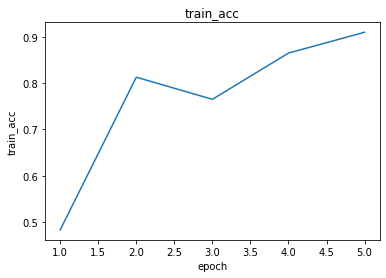

In [83]:
model.plot('train_acc')

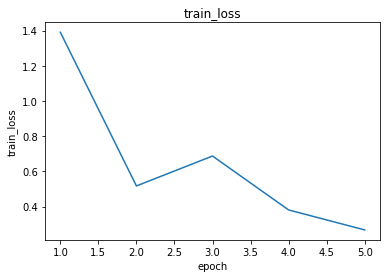

In [84]:
model.plot('train_loss')

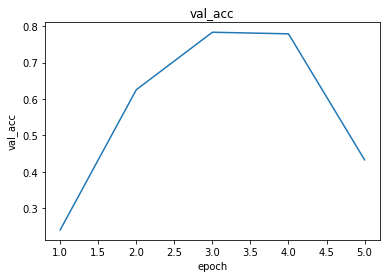

In [85]:
model.plot('val_acc')

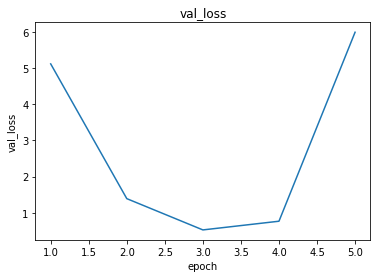

In [86]:
model.plot('val_loss')